# Decision Making Under Uncertainty - Assignment 2

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

## Exercise a.
Derive the product-form solution for the stationary distribution of this Jackson network and determine the stability conditions (consult Lecture on 30 October).

## Exercise b.
Write for this extended system a discrete-event simulation. In order to do this, you might need object-oriented programming.

In [61]:
from scipy import stats
from collections import deque
import heapq
import numpy as np
import matplotlib.pyplot as plt
import statistics

verbose = True

In [143]:
class Customer :

    def __init__(self, arrivalTime, priority):
        self.arrivalTime = arrivalTime
        self.serviceTime = 0
        self.systemArrivalTime = arrivalTime
        self.priority = priority
        self.NQW = 0 #NQW = needy queue waiting time
        self.needyArrivalTime = 0   #a customer arrives only one time in the system
        self.needyQueueArrivalTime = 0
        
        # location: holding, needy, content, out, queue_needy
        self.location = 'holding'
        
    def moveTo(self, location, time, newServiceTime):
        
        assert location.lower() in {'holding', 'needy', 'content', 'out', 'queue_needy'},\
            "Not a proper location. Location should be holding, needy, content, out, or queue_needy"
        
        if self.location.lower() == "holding":
            self.needyArrivalTime = time
        
        if location.lower() == "queue_needy":
            self.needyQueueArrivalTime = time
            
#         if self.location.lower() == "queue_needy":  #you can only move to needy queue
#             assert location.lower() == "needy", "Can only move from needy queue to needy server"
#             self.
            
        self.location = location.lower()
        self.arrivalTime = time
        self.serviceTime = newServiceTime
        
    def leaveSystem(self,time):
        self.location = 'out'
        self.serviceTime = -1
        
        self.sojournTime = time - self.needyArrivalTime
        
    def RegisterTotalNQ(self,time):   # time = t - queue Arrival
        self.NQW += time
        

In [41]:
class Event:

    ARRIVAL = 'ARRIVAL'
    DEPARTURE = 'DEPARTURE'
    
    def __init__(self, typ, time, cust): 
        self.type = typ
        self.time = time
        self.customer = cust
        
    def __lt__(self, other):
        return self.time < other.time
        
    def __str__(self):
        s = ('Arrival', 'Departure')
        return self.type + " of customer " + str(self.customer) + ' at t = ' + str(self.time)


In [42]:
class FES :
    
    def __init__(self):
        self.events = []
        
    def add(self, event):
        heapq.heappush(self.events, event)
        
    def next(self):
        return heapq.heappop(self.events)
    
    def isEmpty(self):
        return len(self.events) == 0
        
    def __str__(self):
        # Note that if you print self.events, it would not appear to be sorted
        # (although they are sorted internally).
        # For this reason we use the function 'sorted'
        s = ''
        sortedEvents = sorted(self.events)
        for e in sortedEvents :
            s += str(e) + '\n'
        return s


In [43]:
class NeedyServer:
    
    def __init__(self, servDist, nrServers=2):
        self.servDist = servDist
        self.nrServers = nrServers
        self.number_of_customers = 0 # Number of customers at this server, not including queue
        
    def __len__(self):
        return self.number_of_customers
        
class ContentServer:
    
    def __init__(self, servDist):
        self.servDist = servDist
        self.number_of_customers = 0
    
    def __len__(self):
        return self.number_of_customers
    

In [165]:
class SimulationResults:
    
    def __init__(self):
        self.results = {
            'blocking_probability': {'high': 0,
                                     'low': 0,
                                     'total': 0},
            'waiting_probability_needy': {'high_priority': 0,
                                          'low_priority': 0},
            'mean_time_in_system': {'high_priority': 0,
                                    'low_priority': 0},
            'mean_waiting_time_in_system': {'high_priority': 0,
                                            'low_priority': 0},
            'mean_waiting_time_to_enter_system': {'high_priority': 0,
                                                  'low_priority': 0},
            'mean_queue_length': {'holding_high_priority': 0,
                                  'holding_low_priority': 0,
                                  'needy': 0},
            'utilisation_needy': 0
        }
        self.results = {}
        self.nS = 0
        
        
        self.number_of_arrivals = {'high': 0, 'low': 0}
        self.number_of_arrivals_waiting = {'high': 0, 'low': 0}
        
        self.total_needy_queue_length = 0
        self.time = 0
        self.sojournTimeList = []
        self.waitingTimes = deque()
        self.sum = 0
        self.needyWaitingTimeList = []
        self.holdingTimeList = {'high_priority': [],
                                    'low_priority': []}
    
    def registerHoldingTime(self, holdingTime, priority):
        if priority=='high': 
            self.holdingTimeList['high_priority'].append(holdingTime)
        else:
            self.holdingTimeList['low_priority'].append(holdingTime)
            
    def registerSojournTime(self, sojournTime):
        self.sojournTimeList.append(sojournTime)
            
    def registerWaitingTime(self, needyWaitingTime):
        self.needyWaitingTimeList.append(needyWaitingTime)  
            
    def getMeanSojournTime(self):
        return statistics.mean(self.sojournTimeList)
    
    def getMeanWaitingTime(self):
        return statistics.mean(self.needyWaitingTimeList)
        
    def register_arrival(self, priority, waiting=False):
        self.number_of_arrivals[priority] += 1

        if waiting:
            self.number_of_arrivals_waiting[priority] += 1
            
    def __str__(self):
        s = 'Mean waiting times: ' + str(self.getMeanWaitingTimes()) + '\n'
        s += 'Mean sojourn time: ' + str(self.getMeanSojournTime()) + '\n'
        return s
    
    def calculate_blocking_probability(self):
        # number of arrivals that have to wait in holding / total number of arrivals
        
        self.results['blocking_probability'] = {priority : self.number_of_arrivals_waiting[priority] / self.number_of_arrivals[priority]
                                               for priority in ('high','low')}
        self.results['blocking_probability']['total'] = sum(self.number_of_arrivals_waiting.values()) / sum(self.number_of_arrivals.values())
        
    
    def update_total_needy_queue_length(self, length):
        self.total_needy_queue_length += length
    
    def update_total_time(self):
        self.time += 1
        

In [187]:
class Network:
    

    def __init__(self, lambda_L, lambda_H, servDist_needy, nrServers, servDist_content, N, p):
        self.arrDist = stats.expon(scale=1/(lambda_L+lambda_H))
        self.high_priority_probability = lambda_H/(lambda_L+lambda_H) # probability for high
        self.N = N
        self.p = p
        
        # Create servers
        self.NeedyServer = NeedyServer(servDist_needy, nrServers)
        self.ContentServer = ContentServer(servDist_content)
        self.simresults = SimulationResults()
        
    def simulate(self, T):
        
        t = 0 # initialise time
        total_needy_queue=0
        
        fes = FES() 
        
        queue_holding_high = deque() # the holding queue for high priority
        queue_holding_low = deque()  # the holding queue for low priority
        queue_needy = deque()        # the queue for needy server
        res = SimulationResults()
        # Generate arrival of the first customer
        u = stats.uniform().rvs()
        
        if u < self.high_priority_probability:
            c0 = Customer(self.arrDist.rvs(), priority='high')
            
        else:
            c0 = Customer(self.arrDist.rvs(), priority='low')
            
        firstEvent = Event(Event.ARRIVAL, c0.arrivalTime, c0)
        fes.add(firstEvent) # schedule first arrival event
        
        # if number people < N: go to needy queue
        while t < T:
            
            e = fes.next()                      # jump to next event
            t = e.time                          # update the time
            c1 = e.customer                     # customer associated with this event
            
            
            number_in_system = len(queue_needy) + len(self.NeedyServer) + len(self.ContentServer)
            
            # Update total number of people that had to wait in the needy queue
            self.simresults.update_total_needy_queue_length(length=len(queue_needy))

            # Update total number of t's
            self.simresults.update_total_time()

            if e.type == 'ARRIVAL':
                
                
                if c1.location == 'holding':
                   
                    # Someone arrive
                    if number_in_system < self.N:
                        
                        # Admit this customer
                        if len(self.NeedyServer) < self.NeedyServer.nrServers:
                            # Admit this customer
                         
                            
                            
                            
                            serviceTime = self.NeedyServer.servDist.rvs()
                            c1.moveTo('needy', t, serviceTime)
                            
                            # Update number of customers at needy server
                            self.NeedyServer.number_of_customers += 1
                            
                            dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                            fes.add(dep)

                        else:
                            # Queue in needy, independent of priority
                            queue_needy.append(c1)
                            c1.moveTo('queue_needy', t, _)
                            
                            
                            
                            
                            
                            
                        self.simresults.register_arrival(priority=c1.priority)
                            
                    else:
                        # else: add to holding queue
                        if c1.priority == 'high':
                            queue_holding_high.append(c1)
                        else:
                            queue_holding_low.append(c1)
                            
                        self.simresults.register_arrival(priority=c1.priority, waiting=True)
                        
                    # Schedule new arrival
                    u = stats.uniform().rvs()

                    if u < self.high_priority_probability:
                        c2 = Customer(self.arrDist.rvs(), priority='high')
                    else:
                        c2 = Customer(self.arrDist.rvs(), priority='low')

                    arrival = Event(Event.ARRIVAL, t + c2.arrivalTime, c2)
                    fes.add(arrival)
                else:
                    raise Exception("ERROR: Arrival from", c1.location)
                    
                
            elif e.type == 'DEPARTURE':
                # Then it's a departure
                      
                
                # Check if departed from needy or from content
                if c1.location == 'content':
                    
                    # Update number of customers at needy server
                    self.ContentServer.number_of_customers -= 1
       
                    
                    
                    if len(self.NeedyServer) < self.NeedyServer.nrServers:
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c1.moveTo('needy', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                    else:
                        queue_needy.append(c1)
                        c1.moveTo('queue_needy', t, _)
                        
                elif c1.location == 'needy':
                    
                    # Update number of customers at needy server
                    self.NeedyServer.number_of_customers -= 1
                    
                    # Admit person from needy queue, if nonempty
                    if len(queue_needy) > 0:
                        c2 = queue_needy.popleft()
                        self.simresults.registerWaitingTime(t - c2.needyQueueArrivalTime)
                        
                        
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c2.moveTo('needy', t, serviceTime)
                        #t = c2.systemArrivalTime

                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1
                       # t = c2.systemArrivalTime

                        dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                        fes.add(dep)
                    
                    # Check if leaves or goes to content
                    u = stats.uniform().rvs()

                    if u < self.p:
                        # Go to content
                        serviceTime = self.ContentServer.servDist.rvs()
                        c1.moveTo('content', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.ContentServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                        
                    else:
                        # Leave system
                        
                        ## Trying to calculate waiting time and sojourn time here. 
                        
                        c1.RegisterTotalNQ(t - c1.needyArrivalTime)
                       
                        ##c1.registerSojournTime(t - c1.needyArrivalTime)
                        
                        c1.leaveSystem(t) # Set c1.location to out and c1.serviceTime to -1
                        #print("needy arrival time:", c1.needyArrivalTime, "- time:", t, "- sojourn: ", c1.sojournTime)
                        #print(self.simresults.sojournTimeList)
                        self.simresults.registerSojournTime(c1.sojournTime)
                        
#                         print("Leaving system", len(queue_holding_high), len(queue_holding_low))
                        # Admit someone from holding queue
                        if len(queue_holding_high) > 0:
                            c2 = queue_holding_high.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                                
                            self.simresults.registerHoldingTime(c2.needyArrivalTime - c2.systemArrivalTime, c2.priority)
                            
                        elif len(queue_holding_low) > 0:
                            c2 = queue_holding_low.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                                
                            self.simresults.registerHoldingTime(c2.needyArrivalTime - c2.systemArrivalTime, c2.priority)
                        else:
                            pass
                        
                        
                else:
                    raise Exception("ERROR: Departure from", c1.location)
        return print("All Done!")

In [202]:
np.random.seed(1)
T = 1000

# Initialise arguments
lambda_L = 2
lambda_H = 1
nrServers = 2
N = 10
p = 0.4

mu = 1
delta = 1

servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=1/float(1/delta))

sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)

sim.simulate(T)

from pprint import pprint

pprint(sim.simresults.holdingTimeList)
print("Mean Sojourn Time:", sim.simresults.getMeanSojournTime())
print("Mean Waiting Time Needy Queue:", sim.simresults.getMeanWaitingTime())

All Done!
{'high_priority': [8.679884920402415,
                   10.777866965048315,
                   13.288239937388237,
                   14.872853517463144,
                   15.183053881835148,
                   15.5240518051005,
                   15.931143316018261,
                   20.406379534148613,
                   20.46050180694024,
                   22.46033067285631,
                   22.838579709595894,
                   24.58149852527956,
                   24.781283400724543,
                   24.593368640511112,
                   26.39494719535239,
                   27.175814783342148,
                   27.73783624005658,
                   29.163929390080163,
                   29.98295582119769,
                   28.95224011823034,
                   30.367955135233128,
                   32.23890394370806,
                   34.58030443826472,
                   36.00588731170614,
                   37.668095884996596,
                   37.809220

In [203]:
[len(x) for x in sim.simresults.holdingTimeList.values()], [statistics.mean(x) for x in sim.simresults.holdingTimeList.values()]

([1011, 204], [503.8428819852262, 538.5577876820782])

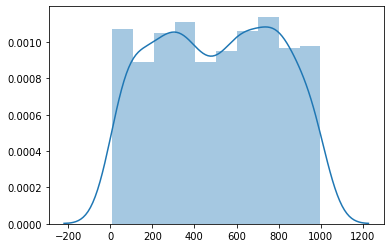

In [204]:
import seaborn as sns

sns.distplot(sim.simresults.holdingTimeList['high_priority'])
plt.show()

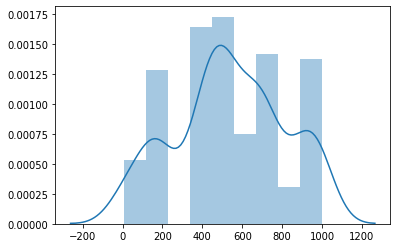

In [205]:
sns.distplot(sim.simresults.holdingTimeList['low_priority'])
plt.show()

In [159]:
sim.simresults.sojournTime

AttributeError: 'SimulationResults' object has no attribute 'sojournTime'

In [32]:
sim.simresults.calculate_blocking_probability()
print("Blocking probability:", sim.simresults.results['blocking_probability'])

q_n = sim.simresults.total_needy_queue_length
print("Total needy queue length:", q_n)
print("Mean needy queue length:", q_n / (T*13))

Blocking probability: {'high': 0.01718213058419244, 'low': 0.015992003998001, 'total': 0.016473156693460354}
Total needy queue length: 143251
Mean needy queue length: 11.019307692307692


## Exercise c.
Use your discrete-event simulation to present performance measures (perhaps probability of blocking for the different customer priority classes, probability of waiting, mean queue length, mean waiting time,...) for the extended system for different values of $\lambda_L$, $\lambda_H$, and $\delta$, and different values of $N$. Elaborate on your findings by creating a comprehensive management report including several sensitivity analyses.

In [33]:
#changing lambda L (and thus fix lambda H)
np.random.seed(1)
runs = 10
T = 100

# Specify which values for lambda_L to test
lambda_L_array = np.linspace(1, 12, runs)

probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_L = lambda_L_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_L equal to", lambda_L)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']

Probability for lambda_L equal to 1.0
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 2.2222222222222223
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 3.4444444444444446
Blocking probability: {'high': 0.013761467889908258, 'low': 0.011976047904191617, 'total': 0.012987012987012988}

Probability for lambda_L equal to 4.666666666666667
Blocking probability: {'high': 0.007692307692307693, 'low': 0.0022624434389140274, 'total': 0.004807692307692308}

Probability for lambda_L equal to 5.888888888888889
Blocking probability: {'high': 0.007481296758104738, 'low': 0.012367491166077738, 'total': 0.010341261633919338}

Probability for lambda_L equal to 7.111111111111112
Blocking probability: {'high': 0.0, 'low': 0.001445086705202312, 'total': 0.0009328358208955224}

Probability for lambda_L equal to 8.333333333333334
Blocking probability: {'high': 0.02278481012658228, 'low': 0.02715466351829988, '

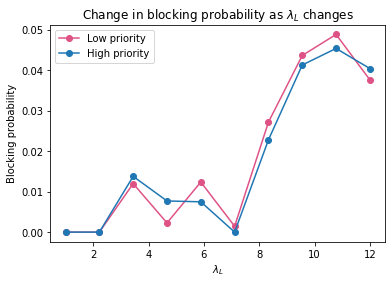

In [34]:
plt.plot(lambda_L_array, probabilities_low, marker='o', color='#de5285', label="Low priority")
plt.plot(lambda_L_array, probabilities_high, marker='o', label="High priority")
plt.xlabel('$\lambda_L$')
plt.ylabel('Blocking probability')
plt.title('Change in blocking probability as $\lambda_L$ changes')
plt.legend(loc='upper left')
plt.show()

In [35]:
#changing lambda H (and thus fix lambda_L)
np.random.seed(1)

# Reset lambda_H and lambda_L
lambda_L = 6
lambda_H = 1

# Specify which values for lambda_H to test
lambda_H_array = np.linspace(1, 12, runs)

probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_H = lambda_H_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculate_blocking_probability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_H equal to", lambda_H)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']

Probability for lambda_H equal to 1.0
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_H equal to 2.2222222222222223
Blocking probability: {'high': 0.00398406374501992, 'low': 0.00974025974025974, 'total': 0.008073817762399077}

Probability for lambda_H equal to 3.4444444444444446
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_H equal to 4.666666666666667
Blocking probability: {'high': 0.0893970893970894, 'low': 0.06217616580310881, 'total': 0.07452830188679245}

Probability for lambda_H equal to 5.888888888888889
Blocking probability: {'high': 0.028764805414551606, 'low': 0.012364760432766615, 'total': 0.020193861066235864}

Probability for lambda_H equal to 7.111111111111112
Blocking probability: {'high': 0.06028833551769332, 'low': 0.05221518987341772, 'total': 0.056630824372759854}

Probability for lambda_H equal to 8.333333333333334
Blocking probability: {'high': 0.05755395683453238, 'low': 0.0504201680672

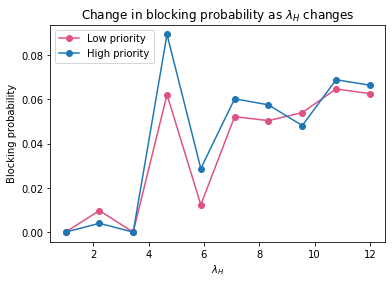

In [36]:
plt.plot(lambda_H_array, probabilities_low, marker='o', color='#de5285', label="Low priority")
plt.plot(lambda_H_array, probabilities_high, marker='o', label="High priority")
plt.xlabel('$\lambda_H$')
plt.ylabel('Blocking probability')
plt.title('Change in blocking probability as $\lambda_H$ changes')
plt.legend(loc='upper left')
plt.show()

In [37]:
# Changing p (comparing the needy queue length)
np.random.seed(1)
N = 25
runs = 10
# Reset lambda_H and lambda_L and initialise p
lambda_L = 6
lambda_H = 4

# Specify which values for p to test
p_array = np.linspace(0, 1, runs)

mean_queue_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    q_n = sim.simresults.total_needy_queue_length 
    time = sim.simresults.time
    print(time)
    q_n_mean = q_n / (time)
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability of not leaving system equal to", p)
        print("Mean queue length: ", q_n_mean)
        print("")
    
    mean_queue_length[i] = q_n_mean

1973
Probability of not leaving system equal to 0.0
Mean queue length:  4.0055752660922455

2362
Probability of not leaving system equal to 0.1111111111111111
Mean queue length:  4.9322607959356475

2493
Probability of not leaving system equal to 0.2222222222222222
Mean queue length:  4.333734456478139

2940
Probability of not leaving system equal to 0.3333333333333333
Mean queue length:  4.447619047619048

3630
Probability of not leaving system equal to 0.4444444444444444
Mean queue length:  4.415702479338843

4620
Probability of not leaving system equal to 0.5555555555555556
Mean queue length:  4.587878787878788

5979
Probability of not leaving system equal to 0.6666666666666666
Mean queue length:  3.7295534370296037

9282
Probability of not leaving system equal to 0.7777777777777777
Mean queue length:  3.6249730661495367

17908
Probability of not leaving system equal to 0.8888888888888888
Mean queue length:  3.5400379718561537



KeyboardInterrupt: 

In [ ]:
Sojourntime = sim.simresults.sojournTimes
print(Sojourntime)
waitingtime = sim.simresults.__str__(self.getMeanWaitingTimes())

In [ ]:
plt.plot(p_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean (needy) queue length')
plt.title('Change in mean (needy) queue length as leaving probability $p$ changes')
plt.show()

In [ ]:
# Changing N (comparing the needy queue length)
np.random.seed(1)
runs=20
T=100

# Reset lambda_H and lambda_L 
lambda_L = 6
lambda_H = 4

# Specify which values for N to test
N_array = np.linspace(10, 1000, runs)

mean_queue_length = np.zeros(runs)

for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    q_n = sim.simresults.total_needy_queue_length 
    time = sim.simresults.time
    
    q_n_mean = q_n / (time)
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("N=", N, "Mean queue length: ", q_n_mean)
        print("")
    
    mean_queue_length[i] = q_n_mean
N = 25

## Exercise d.
Investigate the difference in performance between the original system ($N = 1$) and the extended system (finite $N$). For instance, how fast does the behavior of the extended system mimic the original system behavior as $N$ increases?